In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import xarray as xr
import os
import sys
import glob
import datetime
# Read station metadata from the Excel file
stations = pd.read_excel('/g/data/w28/yk8692/nesp/station/All_stations_information.xlsx')

In [2]:
%%time
file_path = '/g/data/w28/yk8692/nesp'
# Load the Greater Sydney shapefile
gccsa = gpd.read_file(f"{file_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
# gccsa = gpd.read_file("Greater Capital City Statistical Areas - 2021 - Shapefile.shp")
print("Shapefile columns:", gccsa.columns.tolist())
mel_shp = gccsa[gccsa["GCC_NAME21"].str.contains("Melbourne", case=False)]
print("Number of polygons for Greater Melbourne:", len(mel_shp))

# Convert station metadata into a GeoDataFrame.
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Longitude'], stations['Latitude']),
    crs="EPSG:4326"
)

# If necessary, reproject the Sydney shapefile to match the stations' CRS.
if mel_shp.crs != stations_gdf.crs:
    mel_shp = mel_shp.to_crs(stations_gdf.crs)

# Filter stations that fall within the Greater Sydney region.
stations_in_sydney = stations_gdf[stations_gdf.within(mel_shp.unary_union)]
print(f"Found {len(stations_in_sydney)} AWS stations within Greater Melbourne.")

def load_station_data(station_number, data_dir=f'{file_path}/station_corrected_rv'):
    station_num_str = f"{int(station_number):06d}"
    pattern = os.path.join(data_dir, f"HD01D_Data_{station_num_str}_*.nc")
    file_list = glob.glob(pattern)
    if not file_list:
        print(f"No NetCDF files found for station {station_num_str}")
        return None
    try:
        ds = xr.open_mfdataset(file_list, combine='by_coords')
        return ds
    except Exception as e:
        print(f"Error loading station {station_num_str}: {e}")
        return None
# stations_in_sydney = stations_in_sydney[0]

sydney_station_data = {}
for idx, row in stations_in_sydney.iterrows():
    station_num = row["Station_number"]
    ds = load_station_data(station_num)
    if ds is not None:
        key = f"{int(station_num):06d}"
        sydney_station_data[key] = ds

print("Loaded data for the following station(s):", list(sydney_station_data.keys()))

Shapefile columns: ['GCC_CODE21', 'GCC_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry']
Number of polygons for Greater Melbourne: 1
Found 16 AWS stations within Greater Melbourne.
Loaded data for the following station(s): ['086038', '086068', '086071', '086077', '086104', '086266', '086282', '086338', '086361', '086371', '086372', '086383', '086388', '087031', '087185', '088162']
CPU times: user 3min 6s, sys: 12.1 s, total: 3min 18s
Wall time: 4min 56s


In [4]:
# List of station numbers
station_numbers = [
    '086038', '086068', '086077',
    '086282', '086361', 
    '087031', '088162'
]
station_order = ['1','2','4','7','9','14','16']

# Dictionary to store the 99th percentile data for each station
all_stations_99th = {}

# Minimum data availability threshold (80% rule from study)
MIN_VALID_RATIO = 0.8

# Process each station separately
for station in station_numbers:
    # Assume `sydney_station_data` contains the dataset for each station
    data = sydney_station_data.get(station)  # Get data for the station

    # Convert to Pandas DataFrame
    ppt_df = data.to_dataframe().reset_index()
    ppt_df['Time'] = pd.to_datetime(ppt_df['Time'])
    ppt_df = ppt_df.set_index('Time')

    # Define resampling intervals
    resampling_intervals = {
        '5min': '5min', '10min': '10min', '20min': '20min', '30min': '30min', '1h': '1h'
    }
    
    # Convert durations to mm/min normalisation factors
    duration_factors = {'5min': 5, '10min': 10, '20min': 20, '30min': 30, '1h': 60}

    # Initialize a dictionary to store aggregated data
    ppt_aggregated = {}

    for interval, resample_rule in resampling_intervals.items():
        # Resample with mean (ensuring consistent resolution)
        resampled_data = ppt_df['Precipitation'].resample(resample_rule).sum()

        # Compute valid data availability percentage for each period
        valid_counts = ppt_df['Precipitation'].resample(resample_rule).count()
        total_counts = ppt_df['Precipitation'].resample(resample_rule).size()
        valid_ratio = valid_counts / total_counts

        # Apply 80% valid data threshold (remove periods with too much missing data)
        resampled_data[valid_ratio < MIN_VALID_RATIO] = np.nan

        # Store the cleaned resampled data
        ppt_aggregated[interval] = resampled_data / duration_factors[interval] # to mm/min

    # Convert dictionary to DataFrame
    ppt_aggregated_df = pd.DataFrame(ppt_aggregated, index=ppt_df.index)

    # Drop NaNs after filtering for valid periods
    ppt_aggregated_df = ppt_aggregated_df.dropna()

    # Exclude zero values
    nonzero_df = ppt_aggregated_df[ppt_aggregated_df > 0]

    # compute the quantiles on the filtered data
    percentile_99th = nonzero_df.groupby(nonzero_df.index.year) \
                                .quantile(0.99, interpolation='nearest')
    percentile_999th = nonzero_df.groupby(nonzero_df.index.year) \
                                 .quantile(0.999, interpolation='nearest')
    # # Compute the 99% and 99.9% quantiles for extreme precipitation trends
    # percentile_99th = ppt_aggregated_df.groupby(ppt_aggregated_df.index.year).quantile(0.99, interpolation='nearest')
    # percentile_999th = ppt_aggregated_df.groupby(ppt_aggregated_df.index.year).quantile(0.999, interpolation='nearest')

    # # Normalise by dividing by dataset-wide quantiles
    dataset_99th = ppt_aggregated_df.quantile(0.99, interpolation='nearest')  # Compute for entire dataset
    dataset_999th = ppt_aggregated_df.quantile(0.999, interpolation='nearest') # Could cause sampling issue but used to avoid the same values across different years.
    normalised_99th = percentile_99th / dataset_99th
    normalised_999th = percentile_999th / dataset_999th    

    # Store the results
    all_stations_99th[station] = {
        "99th Percentile": normalised_99th,
        "99.9th Percentile": normalised_999th
    }


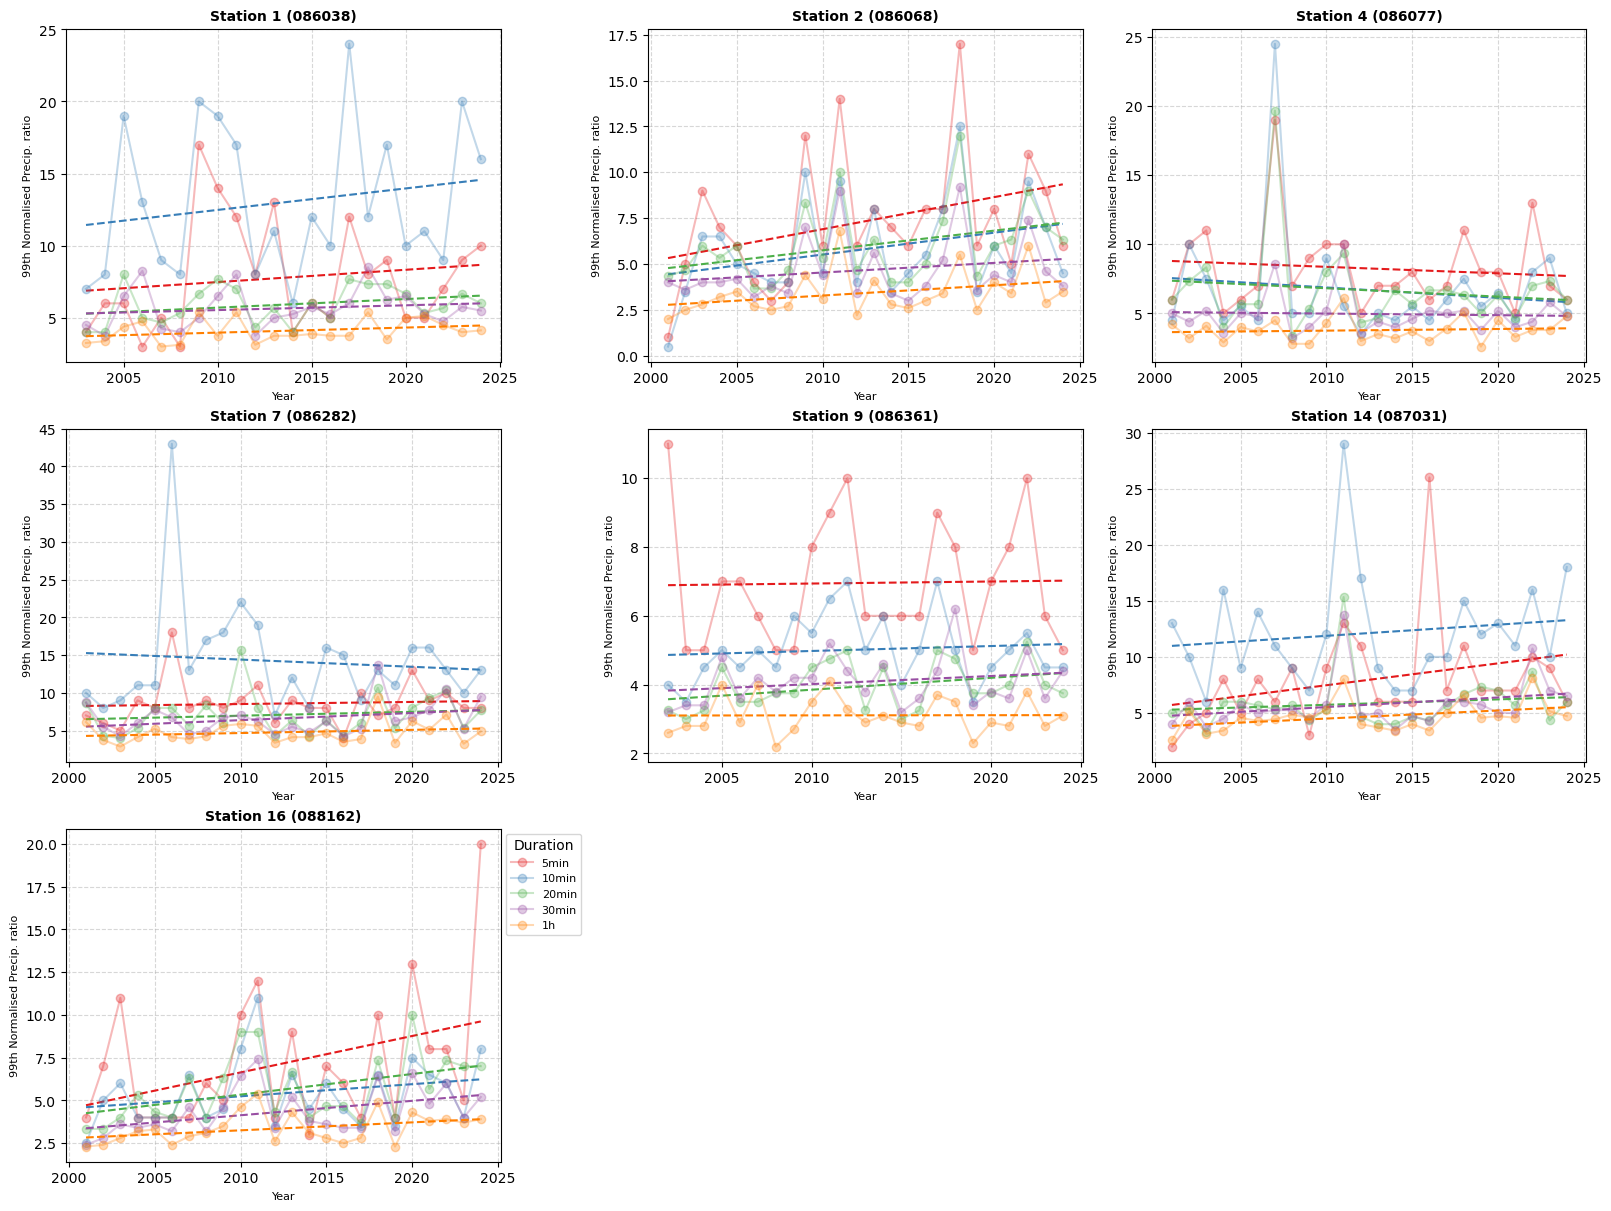

In [5]:
import seaborn as sns
import statsmodels.api as sm

selected_quantile = "99"  # Change this to "99.9" for 99.9% quantile trends

# Define the number of rows and columns for the subplots
nrows, ncols = 3, 3  # 3x3 grid
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12), constrained_layout=True)
axes = axes.flatten()  # Flatten the axes for easier iteration

# Define colors for different precipitation durations
intervals = ['5min', '10min', '20min', '30min', '1h']
colors = sns.color_palette("Set1", len(intervals))  # Unique colors for each duration

# Loop through each station and plot its selected quantile precipitation trend
for i, (station, station_data) in enumerate(all_stations_99th.items()):
    ax = axes[i]

    # Select which quantile to plot (99% or 99.9%)
    station_df = station_data["99th Percentile"] if selected_quantile == "99" else station_data["99.9th Percentile"]

    # Plot each precipitation duration
    for color, column in zip(colors, intervals):
        if column in station_df.columns:
            years = station_df.index.astype(int)  # Convert years to integer format
            values = station_df[column].dropna()  # Drop NaN values

            if len(values) < 5:  # Ensure enough data points
                continue

            # Fit a linear trend line only if there is sufficient data
            if len(values) > 1:  # At least two points needed for a trend line
                coeffs = np.polyfit(years, values, 1)  # Linear fit (degree=1)
                trend_line = np.polyval(coeffs, years)

                # Plot trend line in a lighter shade of the same color
                ax.plot(years, trend_line, linestyle='--', color=color, alpha=1)

            # Plot the selected quantile values
            ax.plot(years, values, marker='o', linestyle='-', color=color, alpha=0.3, label=f'{column}')

    # Customize each subplot
    ax.set_title(f"Station {station_order[i]} ({station})", fontsize=10, fontweight="bold")
    ax.set_xlabel("Year", fontsize=8)
    ax.set_ylabel(f"{selected_quantile}th Normalised Precip. ratio", fontsize=8)  # Updated unit
    ax.grid(True, linestyle="--", alpha=0.5)
    # ax.set_ylim([0.06, 0.2])

    # Add legend only in the empty subplot (e.g., (3,2))
    if i == len(all_stations_99th) - 1:
        ax.legend(title="Duration", fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Display the plot
plt.show()
